# **Персональное кредитное предложение клиентам банка**
Датасет содержит данные о 5000 клиентах банка.

Данные включают демографическую информацию о клиенте (возраст, доход и т.д.), отношения клиента с банком (ипотека, счет ценных бумаг и т.д.) и реакцию клиента на последнюю кампанию по персональному кредитованию (бинарный признак - согласился/отказался).

Задача - построить модель определения клиентов, на которых стоит сфокусировать будущие персональные предложения кредитных продуктов.

# Импорт библиотек

In [273]:
# библиотеки для обработки и анализа структурированных данных
import numpy as np
import pandas as pd

# библиотеки визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# библиотека scikit-learn для машинного обучения
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# библиотека для работы с данными в формате JSON
import json

# библиотека почтовых индексов США
!pip install zipcodes
import zipcodes as zcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Загрузка файла и описание данных

Загружаем данные в датафрейм из CSV-файла

In [274]:
# источник https://www.kaggle.com/datasets/teertha/personal-loan-modeling
url = 'Bank_Personal_Loan.csv'
df = pd.read_csv(url)

Оценим размеры таблицы данных (строки данных, столбцы признаков)

In [275]:
df.shape

(5000, 14)

Выведем информацию о структуре таблицы

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


Выведем первые 10 строк таблицы

In [277]:
df.head(10)

ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   
5   6   37          13      29     92121       4    0.4          2       155   
6   7   53          27      72     91711       2    1.5          2         0   
7   8   50          24      22     93943       1    0.3          3         0   
8   9   35          10      81     90089       3    0.6          2       104   
9  10   34           9     180     93023       1    8.9          3         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1  
5              0                   0           0       1           0  
6              0                   0           0       1           0  
7              0                   0           0       0           1  
8              0                   0           0       1           0  
9              1                   0           0       0           0

Опишем столбцы (признаки):

* `ID` - идентификатор клиента

* `Age` - возраст клиента, полных лет

* `Experience` - стаж работы, лет

* `Income` - годовой доход клиента, тыс. долларов США

* `ZIP Code` - почтовый индекс места жительства клиента 

* `Family` - количество членов семьи клиента

* `CCAvg` - среднемесячный расход по кредитным картам, тыс. долларов США

* `Education` - уровень образования (1 - бакалавриат, 2 - магистратура, 3 - аспирантура)

* `Mortgage` - размер ипотеки, если таковая имеется, тыс. долларов США

* `Personal Loan` - принял ли этот клиент персональное предложение по кредитному продукту?

* `Securities Account` - есть ли у клиента счет ценных бумаг в банке?

* `CD Account` - есть ли у клиента депозитный сертификат (CD) на счет в банке?

* `Online` - пользуется ли клиент услугами интернет-банкинга?

* `CreditCard` - пользуется ли клиент кредитной картой, выпущенной этим банком?

Как видно, все признаки имеют числовые значения.

Признаки `ZIP Сode`, `Family`, `Education`, `Personal Loan`, `Securities Account`, `CD Account`, `Online`, `CreditCard` - категориальные, при этом признаки `Personal Loan`, `Securities Account`, `CD Account`, `Online`, `CreditCard` являются бинарными. Остальные признаки - количественные.

Целевым признаком является `Personal Loan`, таким образом возникает задача **бинарной классификации**.

In [278]:
target_col = ['Personal Loan']

# Предварительная обработка данных

## Проверка на наличие пропущенных значений

In [279]:
df.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

Как видно, ни один из признаков не имеет пропущенных значений.

Признак `ID` обозначает лишь порядковый номер элемента, очевидно не является релевантным и может быть удален.

In [280]:
df.drop(['ID'], axis=1, inplace=True)

## Обработка категориальных признаков

Для категориальных признаков `ZIP Code`, `Family`, `Education`, `Personal Loan`, `Securities Account`, `CD Account`, `Online`, `CreditCard` установим специальный категориальный тип.

In [281]:
category_col = ['ZIP Code', 'Family', 'Education', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
df[category_col] = df[category_col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   ZIP Code            5000 non-null   category
 4   Family              5000 non-null   category
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   category
 7   Mortgage            5000 non-null   int64   
 8   Personal Loan       5000 non-null   category
 9   Securities Account  5000 non-null   category
 10  CD Account          5000 non-null   category
 11  Online              5000 non-null   category
 12  CreditCard          5000 non-null   category
dtypes: category(8), float64(1), int64(4)
memory usage: 260.1 KB


Проверим количество уникальных значений категориальных признаков

In [282]:
df[category_col].nunique()

ZIP Code              467
Family                  4
Education               3
Personal Loan           2
Securities Account      2
CD Account              2
Online                  2
CreditCard              2
dtype: int64

Как можно было предположить, почтовый индекс в данном случае привносит излишнюю детализацию. Имеет смысл сгруппировать данные по более крупным регионам.

In [283]:
# выберем все почтовые индексы из таблицы
zipcodes = df["ZIP Code"].unique()

# сформируем словарь индексов, соотнеся их с округами
zip_county = {}
zip_missed = [] # список не найденных индексов

# для каждого индекса ищем соответствующий ему округ,
# используя метод matching библиотеки zipcodes
# если округ не найден, оставляем индекс по умолчанию
for zipcode in zipcodes:
  county_match = zcode.matching(str(zipcode))
  if len(county_match) == 1:
    county = county_match[0].get('county')
  else:
    county = zipcode
    zip_missed.append(zipcode)
  zip_county.update({zipcode: county})

# выведем список не найденных индексов
zip_missed

[92717, 9307, 92634, 96651]

На сайте http://ru.postcode.info некоторые пропущенные индексы удалось найти. Добавим их в словарь.

In [284]:
zip_county.update({92717: 'Orange County'})
zip_county.update({92634: 'Orange County'})

Добавим новый признак `County`, соотнеся значения столбца `ZIP Code` со словарем индексов.

In [285]:
df['County'] = df['ZIP Code'].map(zip_county)

df['County'].nunique()

40

Добавим новый признак `Region`, соотнеся значения столбца `County` со словарем округов.

In [286]:
# загрузим JSON-файл областей, соответствующих округам
with open('region_county.json', 'r') as f:
  region_county = json.loads(f.read())

df['Region'] = df['County'].map(region_county)

# признаки 'ZIP Code', 'County' можно исключить
df.drop(['ZIP Code', 'County'], axis=1, inplace=True) 

# также для удобства переместим целевой признак в конец таблицы
col_names = list(df.columns)
col_names.remove(target_col[0])
df = df[col_names + target_col]

Проверим новые данные на наличие пропущенных значений.

In [287]:
df.isnull().sum()

Age                   0
Experience            0
Income                0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
Region                7
Personal Loan         0
dtype: int64

Удалим пропущенные значения.

In [288]:
df = df.dropna()

# Разведочный анализ данных (EDA)

## Категориальные признаки

In [289]:
cat_col = ['Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard', 'Region', 'Personal Loan']

### Частотные диаграммы

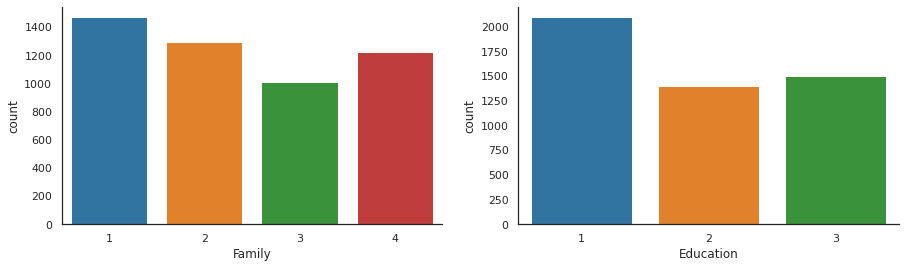

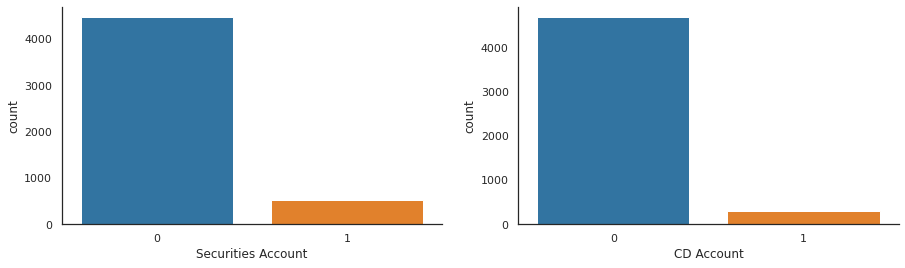

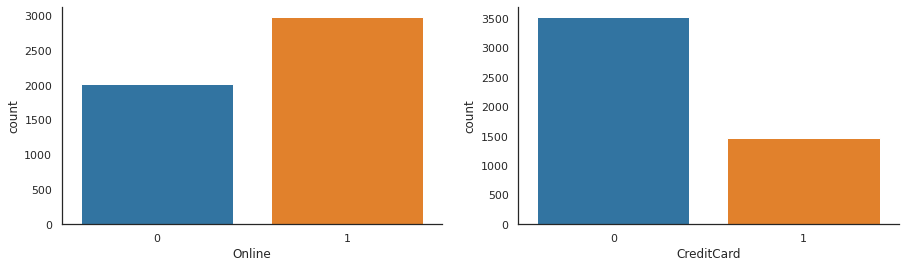

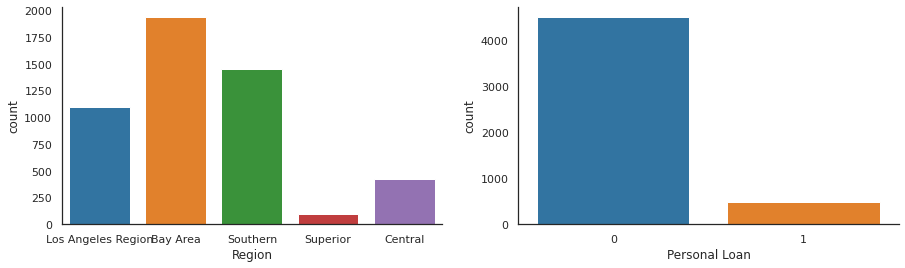

In [290]:
custom_params = {'axes.spines.right': False, 'axes.spines.top': False, 'figure.figsize': (15,4)}
sns.set_theme(style="white", rc=custom_params)
sns.set_palette(sns.color_palette("tab10"))

fig, ax = plt.subplots(1,2)
sns.countplot(x='Family', data=df, ax=ax[0])
sns.countplot(x='Education', data=df, ax=ax[1])
fig.show()

fig, ax = plt.subplots(1,2)
sns.countplot(x='Securities Account', data=df, ax=ax[0])
sns.countplot(x='CD Account', data=df, ax=ax[1])
fig.show()

fig, ax = plt.subplots(1,2)
sns.countplot(x='Online', data=df, ax=ax[0])
sns.countplot(x='CreditCard', data=df, ax=ax[1])
fig.show()

fig, ax = plt.subplots(1,2)
sns.countplot(x='Region', data=df, ax=ax[0])
sns.countplot(x='Personal Loan', data=df, ax=ax[1])
fig.show()

In [291]:
for c in cat_col:
  print(c)
  print(round(df[c].value_counts() * 100 / df[c].count(), 1))
  print('-' * 30)

Family
1    29.4
2    25.9
4    24.4
3    20.2
Name: Family, dtype: float64
------------------------------
Education
1    41.9
3    30.0
2    28.1
Name: Education, dtype: float64
------------------------------
Securities Account
0    89.5
1    10.5
Name: Securities Account, dtype: float64
------------------------------
CD Account
0    94.0
1     6.0
Name: CD Account, dtype: float64
------------------------------
Online
1    59.7
0    40.3
Name: Online, dtype: float64
------------------------------
CreditCard
0    70.6
1    29.4
Name: CreditCard, dtype: float64
------------------------------
Region
Bay Area              38.8
Southern              29.0
Los Angeles Region    21.9
Central                8.4
Superior               1.8
Name: Region, dtype: float64
------------------------------
Personal Loan
0    90.4
1     9.6
Name: Personal Loan, dtype: float64
------------------------------


Из общего числа клиентов лишь 9.6% воспользовались персональным кредитным предложением, т.е. разделение на классы является несбалансированным.

Более половины семей состоит из 1-2 человек.

Чуть более 40% клиентов имеет уровень образования - бакалавриат.

Счет ценных бумаг в банке имеют лишь около 10% клиентов.

6% клиентов имеют депозитный сертификат (CD) на счет в банке.

Почти 60% клиентов пользуются услугами онлайн-банка.

Кредитные карты банка есть примерно у 30% клиентов.



### Кросс-таблицы

Выведем диаграммы распределения клиентов, согласившихся на предложение кредита, по категориальным признакам.

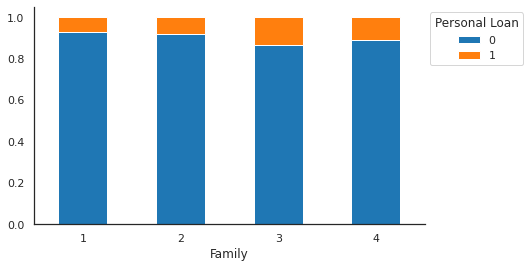

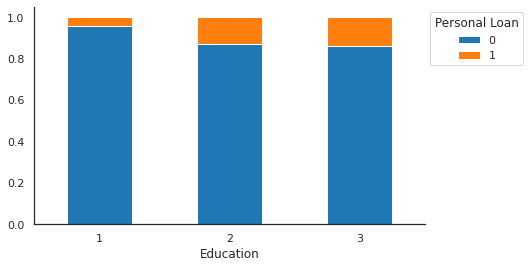

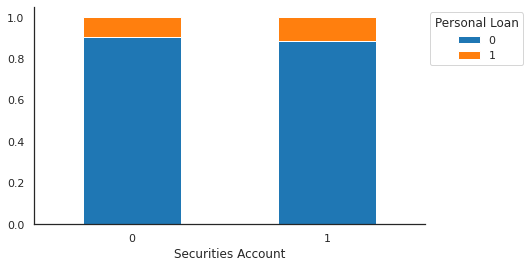

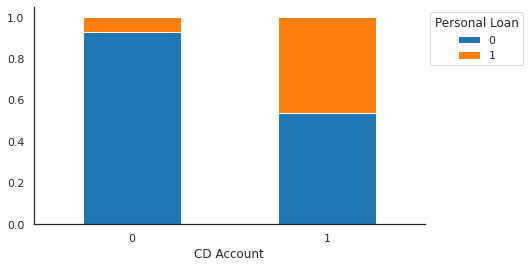

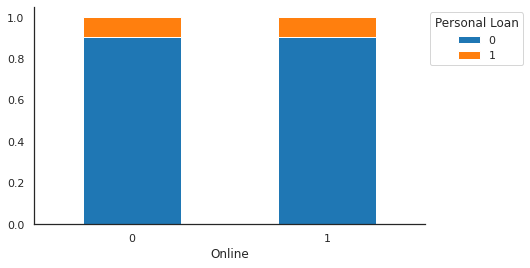

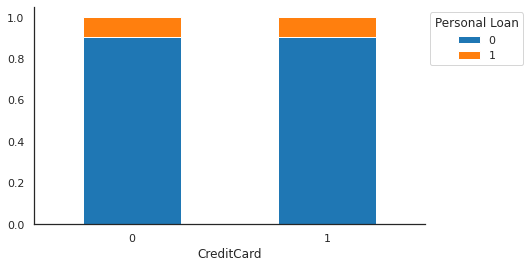

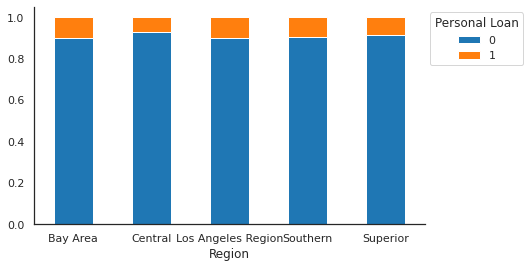

In [292]:
def cat_cross_plot(c):
  sns.set_palette(sns.color_palette("tab10"))
  tab = pd.crosstab(df[c], df['Personal Loan'], normalize='index')
  ax = tab.plot(kind='bar', stacked=True, figsize=(7,4), rot=0)
  plt.legend(title='Personal Loan', bbox_to_anchor=(1,1))
  plt.show()

custom_params = {'axes.spines.right': False, 'axes.spines.top': False, 'figure.figsize': (15,4)}
sns.set_theme(style="white", rc=custom_params)

for c in cat_col:
  if c != 'Personal Loan':
    cat_cross_plot(c)

Семьи, состоящие из 3-х и более человек, более заинтересованы в получении кредитного предложения, как и клиенты, уровень образования которых не ниже магистратуры.

Клиенты, имеющие счет ценных бумаг в банке, чуть чаще принимали кредитное предложение.

Наличие депозитного сертификата (CD) на счет в банке значительно повышает вероятность принятия кредитного предложения.

То, насколько активно клиент пользуется онлайн-банком, практически не оказывает влияние на принятие кредитного предложения, равно как и наличие кредитной карты банка.

Больший интерес к кредитному предложению проявляли клиенты из регионов LosAngeles и Bay.

## Количественные признаки

Выведем описательные характеристики.

In [293]:
df.describe().T

count       mean         std   min   25%   50%    75%    max
Age         4993.0  45.344883   11.461248  23.0  35.0  45.0   55.0   67.0
Experience  4993.0  20.110755   11.466277  -3.0  10.0  20.0   30.0   43.0
Income      4993.0  73.836771   46.032623   8.0  39.0  64.0   98.0  224.0
CCAvg       4993.0   1.939734    1.748169   0.0   0.7   1.5    2.5   10.0
Mortgage    4993.0  56.531744  101.762415   0.0   0.0   0.0  101.0  635.0

Возраст клиентов варьируется от 23 до 67 лет, средний возраст - 45 лет.

Минимальное значение стажа работы -3, что, по всей видимости, является ошибочным значением.

Параметры `Income` и `Mortgage` целесообразно проверить на наличие выбросов.

### Диаграммы рассеивания

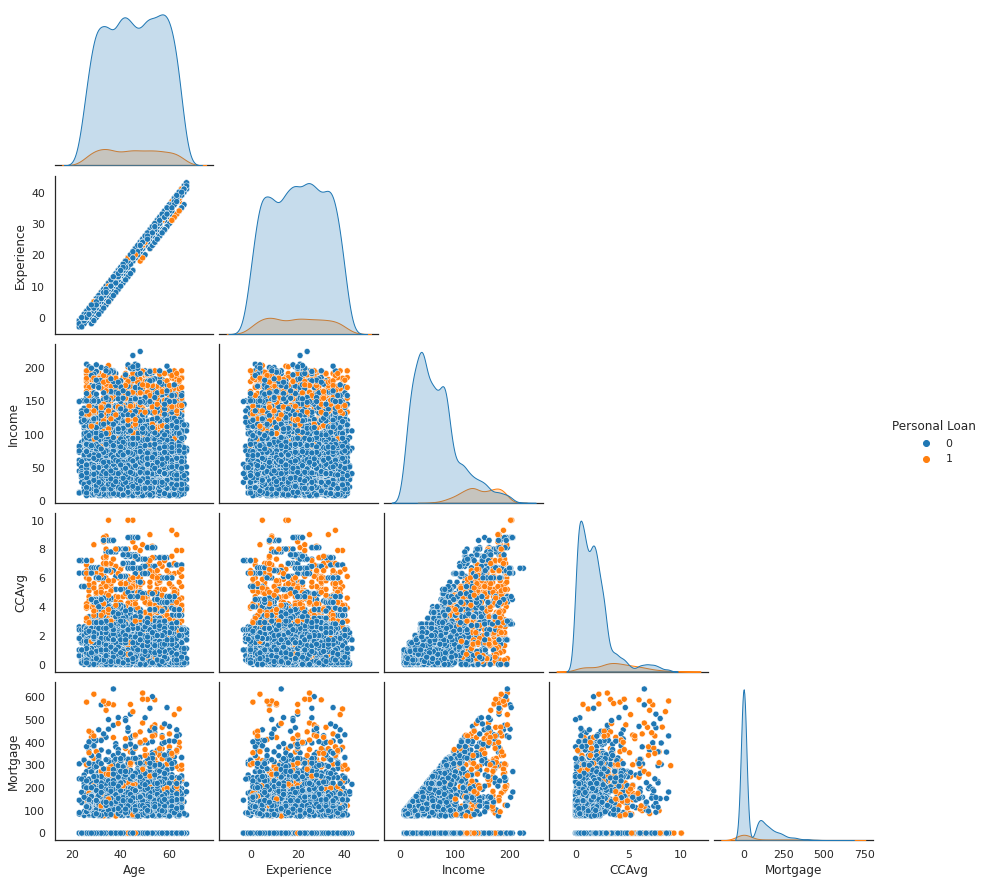

In [294]:
sns.set_palette(sns.color_palette("tab10"))
sns.pairplot(df, hue='Personal Loan', corner=True)
plt.show()

Очевидно, что признаки `Age` и `Experience` имеют сильную линейную зависимость.

Видна зависимость вероятности принятия кредитного предложения от уровня годового дохода клиента, начиная примерно от 90 тыс. долларов США.

Также среднемесячный расход по кредитным картам более 3 тыс. долларов США повышает эту вероятность.

### Матрица корреляции


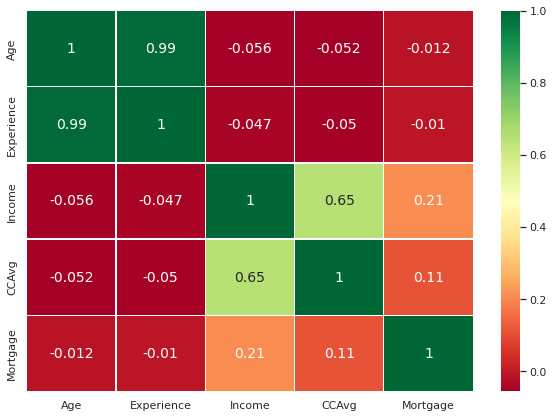

In [295]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':14});

Коллинеарность признаков `Age` и `Experience` подтверждается на диаграмме, т.о. один из них можно исключить. Поскольку признак `Experience`, как было видно выше, содержит некоторые ошибочные данные, он может быть исключен.

In [296]:
df.drop(['Experience'], axis=1, inplace=True)

## Обнаружение выбросов

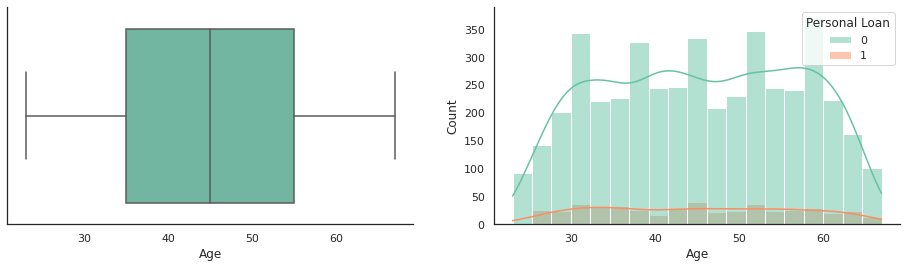

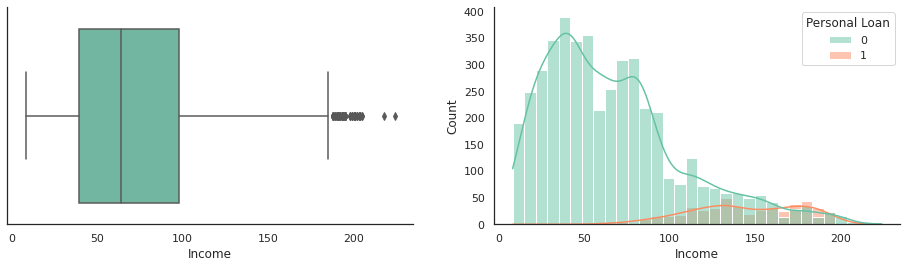

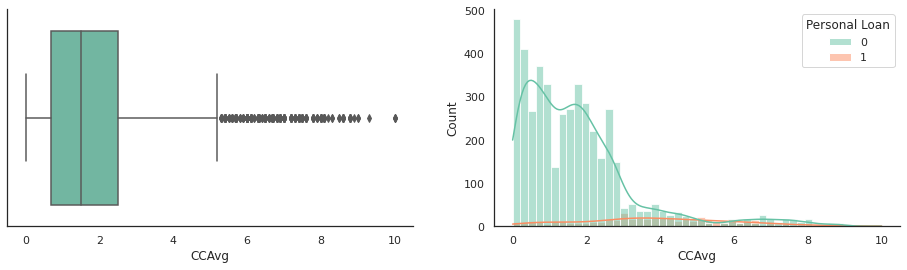

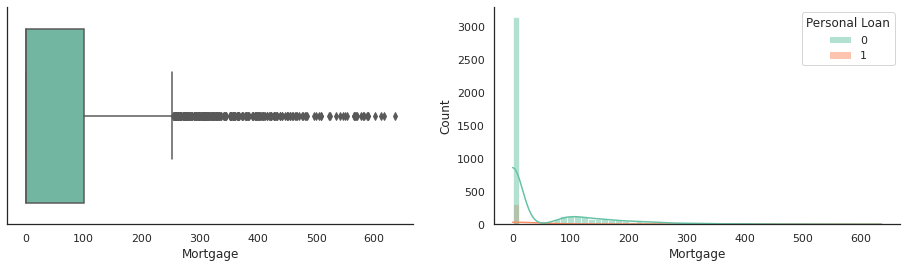

In [297]:
sns.set_palette(sns.color_palette("Set2"))

for c in ['Age', 'Income', 'CCAvg', 'Mortgage']:
  fig, ax = plt.subplots(1, 2, figsize=(16, 4))
  sns.boxplot(x=df[c], ax=ax[0])
  sns.histplot(data=df[[c, 'Personal Loan']], x=df[c], hue='Personal Loan', ax=ax[1], kde=True);
  plt.show()

Признаки `Income`, `CCAvg`, `Mortgage` имеют заметную правостороннюю асимметрию, при этом соответствующее распределение целевого признака `Personal Loan` смещено также вправо.

# Подготовка данных

Сформируем данные для обучения моделей. Выделим целевой признак.

In [298]:
X = df.drop('Personal Loan', axis=1)
Y = df['Personal Loan']

## Кодирование категориальных признаков

Значения категориальных признаков `Education` и `Region` необходимо закодировать.

In [299]:
cat_code_cols = ['Education', 'Region']
X = pd.get_dummies(X, columns=cat_code_cols, drop_first=True)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Age                        4993 non-null   int64   
 1   Income                     4993 non-null   int64   
 2   Family                     4993 non-null   category
 3   CCAvg                      4993 non-null   float64 
 4   Mortgage                   4993 non-null   int64   
 5   Securities Account         4993 non-null   category
 6   CD Account                 4993 non-null   category
 7   Online                     4993 non-null   category
 8   CreditCard                 4993 non-null   category
 9   Education_2                4993 non-null   uint8   
 10  Education_3                4993 non-null   uint8   
 11  Region_Central             4993 non-null   uint8   
 12  Region_Los Angeles Region  4993 non-null   uint8   
 13  Region_Southern            4993 n

## Разделение на обучающую и тестовую выборки

Разделим данные на обучающую и тестовую выборки, выполнив при этом стратификацию данных, что особенно важно при несбалансированных данных.

In [300]:
# определим параметр рандомизации
model_random_state = 100

# разделим данные на тренировочную и тестовую выборки в пропорции 70 / 30
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=model_random_state, stratify=Y)

## Масштабирование данных

In [301]:
# используем стандартный трансформер
scaler = StandardScaler()

# масштабируем обучающую выборку
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку, используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

# Обучение моделей

Для подбора лучшего варианта обучения модели сформируем различные конфигурации классификаторов. Будем использовать следующие методы:
* Логистическая регрессия
* K-ближайших соседей
* Метод опорных векторов
* Дерево принятия решений

Модели на основе логистической регрессии могут обрабатывать большие объемы данных с высокой скоростью и отличаются хорошей интерпретируемостью.

К достоинствам алгоритма K-ближайших соседей можно отнести устойчивость к выбросам и аномальным значениям, понятную интерпретацию.

Метод опорных векторов характеризуется способностью уверенной классификации.

Деревья принятия решений формируют понятные правила классификации, хорошо и быстро интерпретируются, не требуют много параметров модели.

In [317]:
# логистическая регрессия
def get_pipeline_LR():
    pipeline = Pipeline([
        ('clf', LogisticRegression(random_state=model_random_state, max_iter=1000))
    ])
    return pipeline

# k-ближайших соседей
def get_pipeline_KN():
    pipeline = Pipeline([
        ('clf', KNeighborsClassifier())
    ])
    return pipeline

# метод опорных векторов
def get_pipeline_SVC():
    pipeline = Pipeline([
        ('clf', SVC(random_state=model_random_state))
    ])
    return pipeline

# дерево принятия решений
def get_pipeline_DT():
    pipeline = Pipeline([
        ('clf', DecisionTreeClassifier(random_state=model_random_state, max_features=10, min_samples_leaf=2))
    ])
    return pipeline

Зададим функцию обучения модели:
* выбираем проверяемую модель и набор гиперпараметров
* выполняем перебор гиперпараметров классификатора для определения наилучших
* обучаем модель на тренировочной выборке
* тестируем модель на тестовой выборке
* возвращаем оценку и набор гиперпараметров лучшей конфигурации

Для оценки моделей целесообразно использовать метрику **recall**, поскольку в этом случае удастся уменьшить количество ложноотрицательных результатов, что позволит собрать более широкую базу потенциальных клиентов для кредитного предложения.

In [314]:
def train_model(X_train, y_train, X_test, y_test, get_pipeline, parameters):
    # выбираем тестируемую конфигурацию и набор параметров
    pipeline = get_pipeline()

    # выполняем перебор для определения наилучших параметров
    # с использованием метрики recall
    model = GridSearchCV(pipeline, parameters, scoring='recall')
    model.fit(X_train, y_train)

    # получаем набор параметров лучшей конфигурации
    best_parameters = {}
    best_estimator_parameters = model.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        best_parameters[param_name] = best_estimator_parameters[param_name]
    model_results = model.cv_results_

    # выбираем лучшую модель
    predictor = model.best_estimator_

    # обучаем модель на тренировочной выборке
    best_model = predictor.fit(X_train, y_train)

    # тестируем модель
    prediction_train = predictor.predict(X_train)
    prediction_test = predictor.predict(X_test)

    # рассчитываем метрики оценки модели
    model_train_metric = [
        metrics.accuracy_score(prediction_train, y_train),
        metrics.precision_score(prediction_train, y_train),
        metrics.recall_score(prediction_train, y_train),
        metrics.roc_auc_score(prediction_train, y_train)
    ]
    model_test_metric = [
        metrics.accuracy_score(prediction_test, y_test),
        metrics.precision_score(prediction_test, y_test),
        metrics.recall_score(prediction_test, y_test),
        metrics.roc_auc_score(prediction_test, y_test)
    ]

    # возвращаем параметры модели и метрики
    return model_results, best_parameters, model_train_metric, model_test_metric

# Проведение экспериментов и оценка моделей

Зададим функцию проведения эксперимента и вывода результатов.

In [315]:
def do_experiment(ex):
    model_results, best_parameters, model_train_metric, model_test_metric = train_model(X_train_scaled, y_train, X_test_scaled, y_test, ex[1], ex[2])
    print("Модель:", ex[0])
    print(f"              train   test")
    print(f"   Accuracy:  {model_train_metric[0]:.2f}    {model_test_metric[0]:.2f}")
    print(f"  Precision:  {model_train_metric[1]:.2f}    {model_test_metric[1]:.2f}")
    print(f"     Recall:  {model_train_metric[2]:.2f}    {model_test_metric[2]:.2f}")
    print(f"    ROC_AUC:  {model_train_metric[3]:.2f}    {model_test_metric[3]:.2f}")
    print("Лучший набор гиперпараметров:")
    for param_name in sorted(best_parameters.keys()):
        print(f"\t{param_name.replace('clf__', '')}: {best_parameters[param_name]}")
    print("-" * 30)
    print("")

    # визуализируем подбор гиперпараметров
    if ex[3]:
      parameters = ex[2]
      keys = list(parameters.keys())
      p = keys[0]
      loss = 1.0 - model_results['mean_test_score'][0:len(p)]
      plt.plot(parameters[p], loss, 'g')
      plt.xlim([min(parameters[p]), max(parameters[p])])
      plt.grid()
      plt.xlabel(ex[0] + ': ' + p.replace('clf__', ''))

Для каждой конфигурации указываем набор гиперпараметров и перечень значений, используемых для подбора наилучшего сочетания.

Проведем эксперименты для всех заданных конфигураций.

Модель: Логистическая регрессия
              train   test
   Accuracy:  0.96    0.96
  Precision:  0.68    0.64
     Recall:  0.87    0.91
    ROC_AUC:  0.92    0.94
Лучший набор гиперпараметров:
	C: 1
	solver: newton-cg
------------------------------

Модель: K-ближайших соседей
              train   test
   Accuracy:  0.97    0.95
  Precision:  0.70    0.48
     Recall:  0.97    0.91
    ROC_AUC:  0.97    0.93
Лучший набор гиперпараметров:
	leaf_size: 2
	n_neighbors: 3
------------------------------

Модель: Метод опорных векторов
              train   test
   Accuracy:  0.99    0.98
  Precision:  0.87    0.76
     Recall:  0.99    0.98
    ROC_AUC:  0.99    0.98
Лучший набор гиперпараметров:
	C: 2
	kernel: rbf
------------------------------

Модель: Дерево принятия решений
              train   test
   Accuracy:  0.99    0.99
  Precision:  0.94    0.88
     Recall:  0.99    0.97
    ROC_AUC:  0.99    0.98
Лучший набор гиперпараметров:
	max_depth: 9
------------------------------



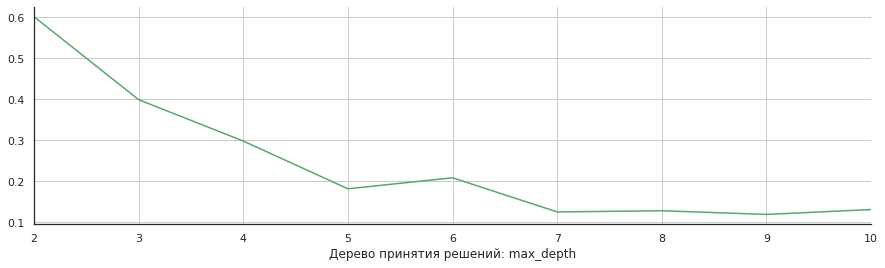

In [319]:
# список экспериментов
experiments = [
    ['Логистическая регрессия', get_pipeline_LR, {
        'clf__C': [0.01, 0.1, 1],
        'clf__solver': ['newton-cg', 'liblinear']
      }, False],
    ['K-ближайших соседей', get_pipeline_KN, {
        'clf__leaf_size': range(2, 5),
        'clf__n_neighbors': range(2, 9)
      }, False],
    ['Метод опорных векторов', get_pipeline_SVC, {
        'clf__C': [0.01, 0.1, 1, 2],
        'clf__kernel': ['poly', 'rbf', 'sigmoid']
      }, False],
    ['Дерево принятия решений', get_pipeline_DT, {
        'clf__max_depth': range(2, 11),
      }, True] # для дерева принятия решения построим визуализацию
]

for ex in experiments:
    do_experiment(ex)

# Выводы

Все модели, в особенности использующие метод опорных векторов и дерево принятия решений, показали хорошие результаты как на тренировочной, так и на тестовой выборке.

Метрика, используемая в процессе обучения, позволяет увеличить широту охвата потенциальных клиентов для персонального кредитного предложение банка.

Для повышения эффективности дальнейшей работы стоит сфокусироваться на следующих категориях клиентов:

* из семей, состоящих из 3-х и более человек;
* имеющие уровень образования не ниже магистратуры;
* имеющие счет ценных бумаг в банке;
* имеющие депозитный сертификат (CD) на счет в банке;
* с высоким уровнем годового дохода, от 90 тыс. долларов США;
* со среднемесячным расходом по кредитным картам не менее 3 тыс. долларов США.